#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [45]:
!pip3 install numpy pandas matplotlib nltk 

  Using cached numpy-2.2.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached numpy-2.2.0-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 1.7.5 requires scipy, which is not installed.


In [46]:
import sklearn
import nltk
import numpy as np
import pandas as pd
import matplotlib as plt


nltk.download('punkt_tab'), nltk.download('stopwords'), nltk.download('wordnet'), nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /Users/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(True, True, True, True)

In [47]:
df = pd.read_csv("combined_data.csv")
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [48]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) # подгрузили стоп-слова
lemmatizer = WordNetLemmatizer() # подгрузили лемматизатор (лемматизатор анализирует слово и преобразует его в начальную форму, учитывая его морфологические характеристики и контекст. например, слова "бегу", "бегут" будут преобразованы в лемму "бег". лемматизация помогает нормализовать слова для обработки текста.)

def preproc(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # по регулярке оставляем только текст
    return ' '.join([t for t in word_tokenize(text) if t not in stop_words and t.strip() != '']) # токенизируем и удаляем стоп-слова

def lemma(text: str) -> str:
    return ' '.join([lemmatizer.lemmatize(t) for t in word_tokenize(text)]) # лемматизируем

df['clean_text'] = df['text'].apply(preproc)
df['clean_text'] = df['clean_text'].apply(lemma)

df.head()

,label,text,clean_text
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...


In [49]:
from sklearn.model_selection import train_test_split

X, y = df['clean_text'], df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=148, stratify=y
)

X_train.shape, X_test.shape

((66758,), (16690,))

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
bow_vectorizer = CountVectorizer() # считает количество вхождений слов в документ. например, если у нас есть 2 документа: "hello world" и "hello", то векторизация будет такой: "hello" - 2, "world" - 1
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer() # считает вес слова в документе. например, если у нас есть 2 документа: "hello world" и "hello", то векторизация будет такой: "hello" - 0.5, "world" - 0.5
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_bow.shape, X_train_tfidf.shape

((66758, 237122), (66758, 237122))

In [61]:
!pip uninstall -y scikit-learn numpy scipy joblib threadpoolctl
!pip uninstall xgboost scikit-learn -y
!pip install scikit-learn==1.5.2 --user
!pip install xgboost==1.7.5 --user

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
Found existing installation: numpy 2.2.0
Uninstalling numpy-2.2.0:
  Successfully uninstalled numpy-2.2.0
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: joblib 1.4.2
Uninstalling joblib-1.4.2:
  Successfully uninstalled joblib-1.4.2
Found existing installation: threadpoolctl 3.5.0
Uninstalling threadpoolctl-3.5.0:
  Successfully uninstalled threadpoolctl-3.5.0
Found existing installation: xgboost 1.7.5
Uninstalling xgboost-1.7.5:
  Successfully uninstalled xgboost-1.7.5
  Using cached scikit_learn-1.5.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (13 kB)
  Using cached numpy-2.2.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scipy-1.14.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


def search_params(model, param_grid, X_train, y_train):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    return grid

xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}
print("[+] XGBoost")
# xgb_grid_bow = search_params(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=148), xgb_params, X_train_bow, y_train)

lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}
print("[+] Логистическая регрессия")
lr_grid_bow = search_params(LogisticRegression(random_state=148), lr_params, X_train_bow, y_train)

rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
print("[+] Random Forest")
rf_grid_bow = search_params(RandomForestClassifier(random_state=148), rf_params, X_train_bow, y_train)


[+] XGBoost
[+] Логистическая регрессия
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0

[+] Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from v

Результаты для модели LogisticRegression (BoW):
Accuracy:   0.9845
Precision:  0.9796
Recall:     0.9912
F1-Score:   0.9854
ROC-AUC:    0.9961


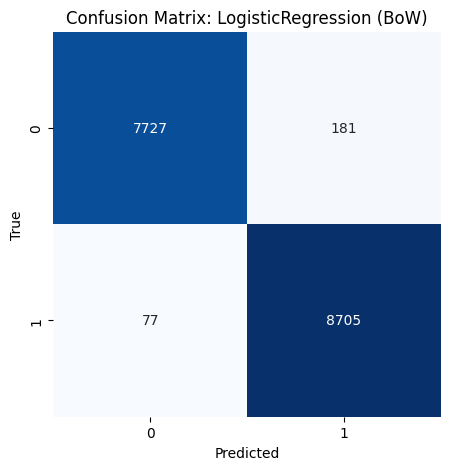

Результаты для модели RandomForest (BoW):
Accuracy:   0.9782
Precision:  0.9869
Recall:     0.9714
F1-Score:   0.9791
ROC-AUC:    0.9978


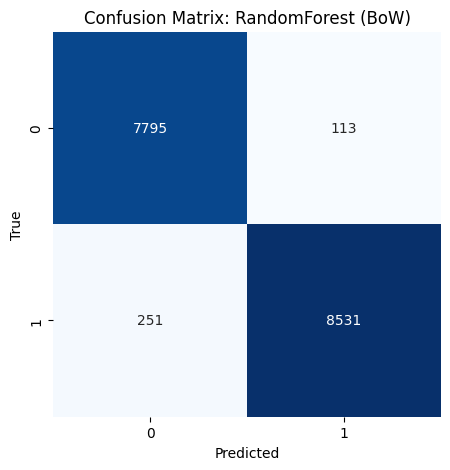

In [ ]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc = None
    print(f"Результаты для модели {model_name}:")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-Score:   {f1:.4f}")
    if roc is not None:
        print(f"ROC-AUC:    {roc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

best_lr_bow = lr_grid_bow.best_estimator_
best_rf_bow = rf_grid_bow.best_estimator_
#best_xgb_bow = xgb_grid_bow.best_estimator_

for model, name in [(best_lr_bow, "LogisticRegression (BoW)"),
                    (best_rf_bow, "RandomForest (BoW)")]:
    evaluate_model(model, X_test_bow, y_test, name)

In [69]:
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}
print("[+] XGBoost")
# xgb_grid_bow = search_params(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=148), xgb_params, X_train_tfidf, y_train) (сколько ни пытался завести под mac, не вышло, там нужно держать scikit-learn==1.5.2, но питон 3.13.1 буквально игнорировал мои увещевания, а под 3.9.6 тоже не вышло)

lr_params = {
    'C': [0.5, 1],
    'max_iter': [50, 100]
}
print("[+] Логистическая регрессия")
lr_grid_tf = search_params(LogisticRegression(random_state=148), lr_params, X_train_tfidf, y_train)

rf_params = {
    'n_estimators': [30, 50],
    'max_depth': [None, 10]
}
print("[+] Random Forest")
rf_grid_tf = search_params(RandomForestClassifier(random_state=148), rf_params, X_train_tfidf, y_train)

[+] XGBoost
[+] Логистическая регрессия
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0

[+] Random Forest
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from v

Результаты для модели LogisticRegression (TF_IDF):
Accuracy:   0.9833
Precision:  0.9763
Recall:     0.9924
F1-Score:   0.9842
ROC-AUC:    0.9978


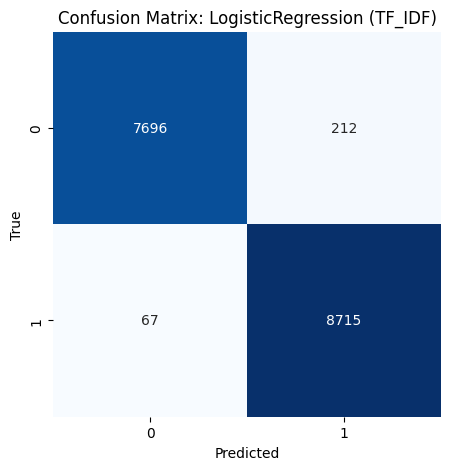

Результаты для модели RandomForest (TF_IDF):
Accuracy:   0.9815
Precision:  0.9857
Recall:     0.9792
F1-Score:   0.9824
ROC-AUC:    0.9980


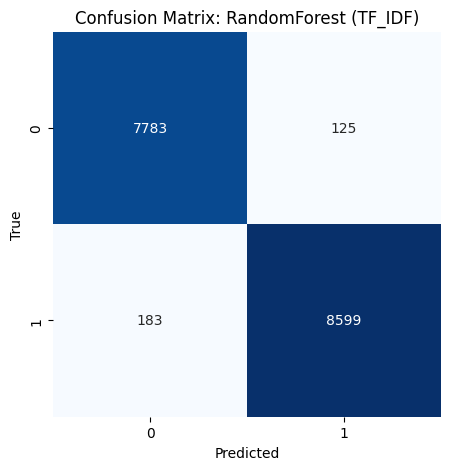

In [70]:
best_lr_tf = lr_grid_tf.best_estimator_
best_rf_tf = rf_grid_tf.best_estimator_
#best_xgb_bow = xgb_grid_bow.best_estimator_

for model, name in [(best_lr_tf, "LogisticRegression (TF_IDF)"),
                    (best_rf_tf, "RandomForest (TF_IDF)")]:
    evaluate_model(model, X_test_tfidf, y_test, name)

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

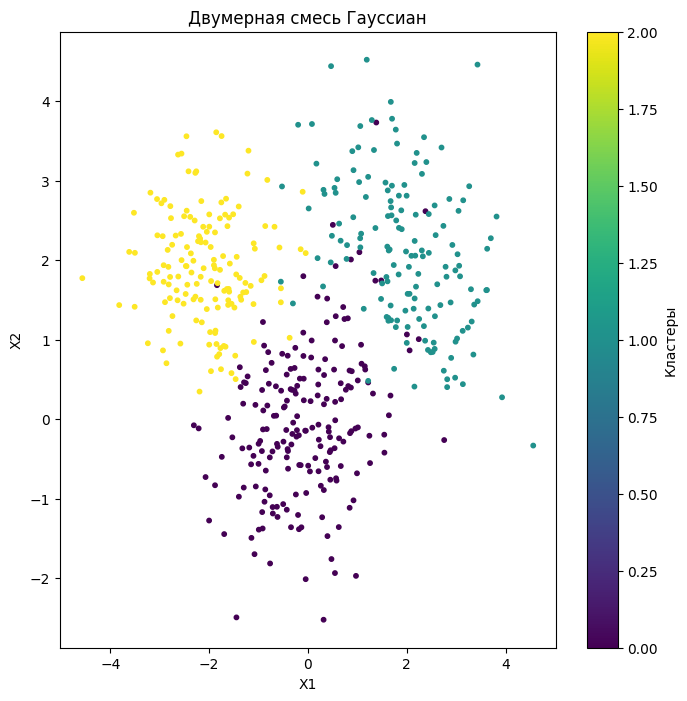

In [71]:
np.random.seed(148)

n_samples, cluster_means, cluster_covariances, cluster_weights = 500, \
    [[0, 0], [2, 2], [-2, 2]], \
    [[[0.8, 0.3], [0.3, 0.8]], [[0.8, -0.3], [-0.3, 0.8]], [[0.5, 0], [0, 0.5]]], \
    [0.4, 0.3, 0.3]

# инициализируем
X, labels, current = np.zeros((n_samples, 2)), np.zeros(n_samples, dtype=int), 0

# генерация выборок для каждого кластера
for idx, (mean, cov, weight) in enumerate(zip(cluster_means, cluster_covariances, cluster_weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current:current + n_cluster_samples, :], labels[current:current + n_cluster_samples] = \
        np.random.multivariate_normal(mean, cov, n_cluster_samples), np.full(n_cluster_samples, idx)
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeans or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and 

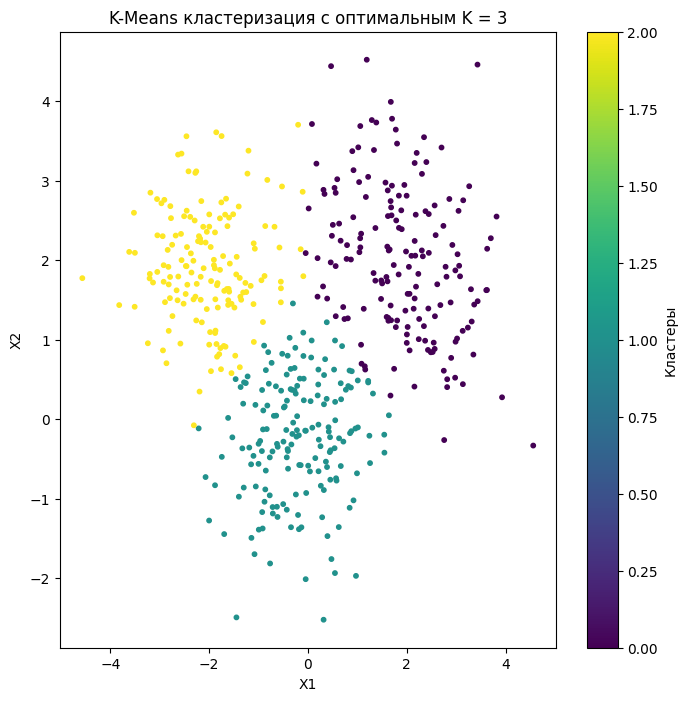

оптимальное количество кластеров (K): 3
силуэтный коэффициент для оптимального K: 0.49119907178448147


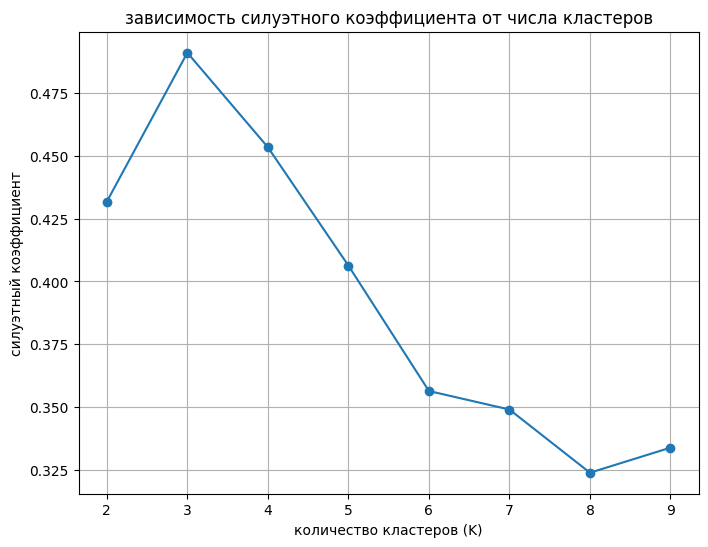

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 10)

# список для хранения значений силуэтного коэффициента
silhouette_scores = []

# Пробуем разные значения K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=148, n_init=10)  # KMeans
    cluster_labels = kmeans.fit_predict(X)  # прогон данных через модель
    silhouette_avg = silhouette_score(X, cluster_labels)  # рассчитываем силуэтный коэффициент
    silhouette_scores.append(silhouette_avg)


optimal_k = k_values[np.argmax(silhouette_scores)]
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=148, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_optimal, cmap='viridis', s=10)
plt.title(f"K-Means кластеризация с оптимальным K = {optimal_k}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

print(f"оптимальное количество кластеров (K): {optimal_k}")
print(f"силуэтный коэффициент для оптимального K: {np.max(silhouette_scores)}")

plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('количество кластеров (K)')
plt.ylabel('силуэтный коэффициент')
plt.title('зависимость силуэтного коэффициента от числа кластеров')
plt.xticks(k_values)
plt.grid(True)
plt.show()


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The DBSCAN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and 

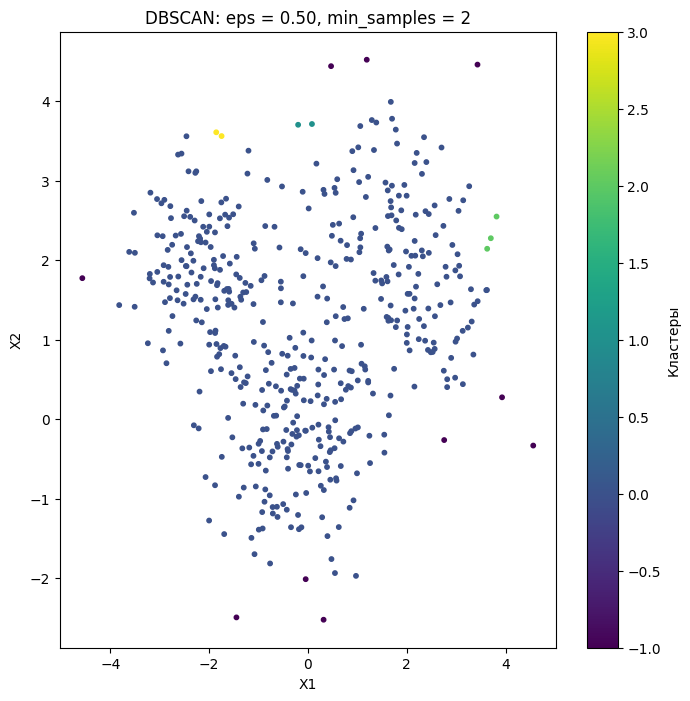

оптимум eps: 0.50
оптимум min_samples: 2
BCubed (ARI): 0.003808576203019089


In [79]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt

# диапазон значений для гиперпараметров
eps_range = np.linspace(0.5, 2, 10)
min_samples_range = range(2, 10)

best_score = -1
optimal_eps = -1
optimal_min_samples = -1

for eps in eps_range:
    for samples in min_samples_range:
        model = DBSCAN(eps=eps, min_samples=samples)
        labels_pred = model.fit_predict(X)

        # вычисляем метрику
        score = adjusted_rand_score(labels, labels_pred)

        if score > best_score:
            best_score = score
            optimal_eps = eps
            optimal_min_samples = samples

# обучение с оптимальными параметрами
optimal_model = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
optimal_labels = optimal_model.fit_predict(X)

# визуализация результата
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=optimal_labels, cmap='viridis', s=10)
plt.title(f"DBSCAN: eps = {optimal_eps:.2f}, min_samples = {optimal_min_samples}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

print(f"оптимум eps: {optimal_eps:.2f}")
print(f"оптимум min_samples: {optimal_min_samples}")
print(f"BCubed (ARI): {best_score}")

**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

/var/folders/j1/2k874v3j10j486j3c3tzmync0000gn/T/ipykernel_19767/2256887482.py:37: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(np.log(np.sum(resp * np.array(log_probs).T, axis=1)))


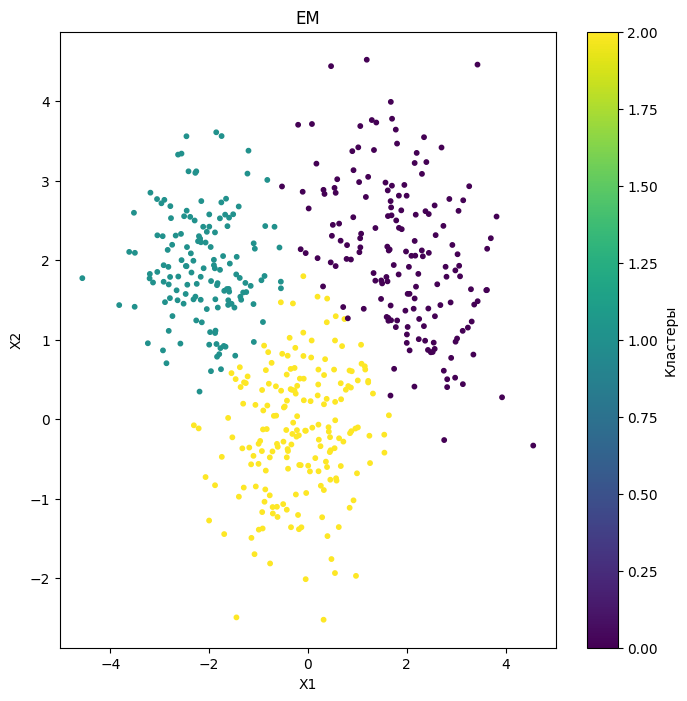

индекс согласованности по Rand: 0.8417401089522232


In [83]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

"""
алгоритм EM для кластеризации смеси гауссовских распределений успешно разделил данные на кластеры. на основе индекса согласованности по Rand (ARI), EM алгоритм показал схожие результаты с GMM, так как оба используют схожие подходы. выбор между ними зависит от задачи: EM полезен для гибкой реализации, а GMM — готовое решение
"""

def run_em(X, clusters, iterations=100, tolerance=1e-4):
    samples, features = X.shape

    # инициализация параметров
    centroids = X[np.random.choice(samples, clusters, replace=False)]
    cov_matrices = [np.eye(features) for _ in range(clusters)]
    weights = np.ones(clusters) / clusters

    log_likelihood_history = []

    for _ in range(iterations):
        # e-шаг: расчёт ответственности
        resp = np.zeros((samples, clusters))
        for i in range(clusters):
            resp[:, i] = weights[i] * multivariate_normal.pdf(X, mean=centroids[i], cov=cov_matrices[i])
        resp /= resp.sum(axis=1, keepdims=True)

        # m-шаг: обновление параметров
        cluster_sizes = resp.sum(axis=0)
        weights = cluster_sizes / samples
        for i in range(clusters):
            centroids[i] = (resp[:, i, np.newaxis] * X).sum(axis=0) / cluster_sizes[i]
            diff = X - centroids[i]
            cov_matrices[i] = np.dot(resp[:, i] * diff.T, diff) / cluster_sizes[i]

        # расчёт логарифмической правдоподобности
        log_probs = [multivariate_normal.logpdf(X, mean=centroids[i], cov=cov_matrices[i]) for i in range(clusters)]
        log_likelihood = np.sum(np.log(np.sum(resp * np.array(log_probs).T, axis=1)))
        log_likelihood_history.append(log_likelihood)

        # проверка на сходимость
        if len(log_likelihood_history) > 1 and abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tolerance:
            break

    labels = np.argmax(resp, axis=1)
    return labels, centroids, cov_matrices, weights

# выполнение алгоритма em
clusters = 3
em_labels, centroids, cov_matrices, weights = run_em(X, clusters)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=em_labels, cmap='viridis', s=10)
plt.title("EM")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# расчет ARI для EM
ari = adjusted_rand_score(labels, em_labels)
print(f"индекс согласованности по Rand: {ari}")

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/user/Library/Python/3.13/lib/python/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeans or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Clas

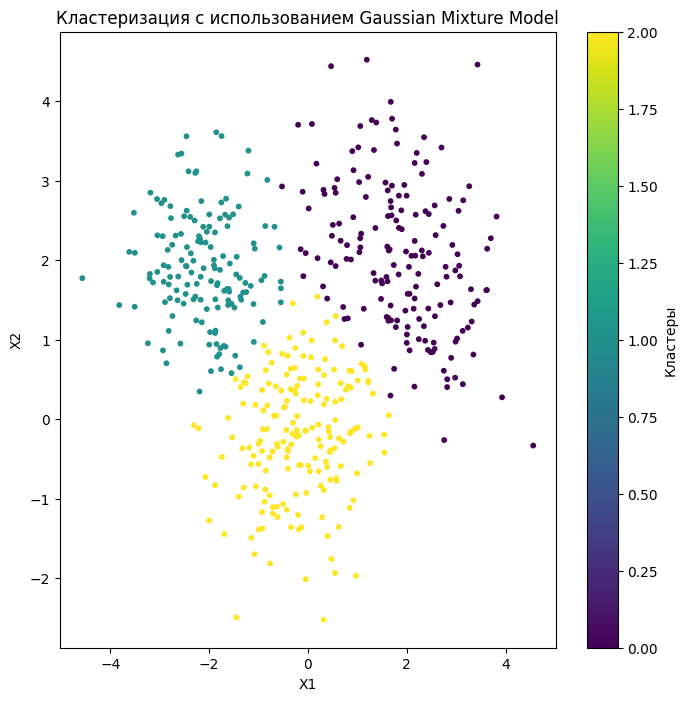

индекс согласованности по Rand для GMM: 0.8251949437680577


In [80]:
"""
Gaussian Mixture Model (GMM) — это модель, которая разбивает данные на кластеры, считая, что они образоаны несколькими гауссовскими распределениями. алгоритм EM поочерёдно определяет, какому кластеру скорее всего принадлежит каждая точка (E-шаг), и уточняет параметры этих кластеров (M-шаг). всё повторяется, пока результат не стабилизируется
"""

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# создание и обучение модели Gaussian Mixture
gmm_model = GaussianMixture(n_components=3, random_state=42)  # предполагаем 3 кластера
gmm_predictions = gmm_model.fit_predict(X)

# визуализация результатов кластеризации
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_predictions, cmap='viridis', s=10)
plt.title("Кластеризация с использованием Gaussian Mixture Model")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# расчет ARI для GMM
ari_gmm = adjusted_rand_score(labels, gmm_predictions)
print(f"индекс согласованности по Rand для GMM: {ari_gmm}")